# Importing Required Libraries

In [ ]:
%pip install statsmodels
%pip install sklearn
%pip install xgboost
%pip install lightgbm


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.decomposition import PCA
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error,mean_squared_error
from sklearn.linear_model import Ridge,ElasticNet,Lasso,LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,ShuffleSplit
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, KFold
import pickle

import warnings
warnings.filterwarnings("ignore")

seed = 10

# Exploratory Data Analysis:

In [5]:
df= pd.read_csv(r"Copy of energy_production .csv")

In [75]:
df.head()

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
0,9.59,38.56,1017.01,60.10,481.30
1,12.04,42.34,1019.72,94.67,465.36
2,13.87,45.08,1024.42,81.69,465.48
3,13.72,54.30,1017.89,79.08,467.05
4,15.14,49.64,1023.78,75.00,463.58


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        9568 non-null   float64
 1   exhaust_vacuum     9568 non-null   float64
 2   amb_pressure       9568 non-null   float64
 3   r_humidity         9568 non-null   float64
 4   energy_production  9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


### The dataset contains 9,568 rows and 5 columns, all of which are numeric (float datatype), with no missing values.

In [61]:
print("Count of duplicated values:",df.duplicated().sum())
print("Percentage of duplicates:",np.round(((df.duplicated().sum())/df.shape[0])*100,2))

Count of duplicated values: 41
Percentage of duplicates: 0.43


### We will drop all the 41 duplicated values as this is only 0.43% of data.

In [30]:
df.describe()

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


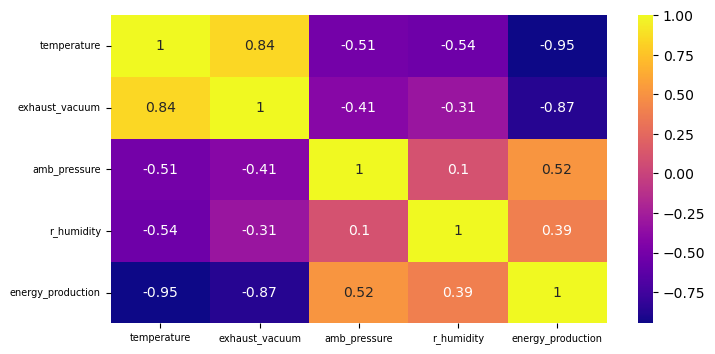

In [29]:
corr=df.corr()

plt.figure(figsize=(8,4))
sns.heatmap(corr, annot=True, cmap='plasma')
plt.xticks(fontsize=7,rotation=360)
plt.yticks(fontsize=7)
plt.show()

## Assessing Collinearity with the Output Variable: Energy Production 

In [293]:
corr['energy_production']

temperature         -0.948128
exhaust_vacuum      -0.869780
amb_pressure         0.518429
r_humidity           0.389794
energy_production    1.000000
Name: energy_production, dtype: float64

- Temperature and exhaust vaccum show a strong correlation with the output variable (energy production).
- Ambient pressure has a moderate correlation.
- However, relative humidity has a low correlation, with a value of 0.389.9.

## Multicollinearity between input variables: 

In [32]:
# Flatten the correlation matrix and filter
high_correlations = corr.drop('energy_production', axis=1).drop('energy_production', axis=0).unstack().sort_values(ascending=False)
high_correlations[(np.abs(high_correlations) > 0.5) & (high_correlations < 1)]

temperature     exhaust_vacuum    0.844107
exhaust_vacuum  temperature       0.844107
temperature     amb_pressure     -0.507549
amb_pressure    temperature      -0.507549
temperature     r_humidity       -0.542535
r_humidity      temperature      -0.542535
dtype: float64

- The input variables, temperature and exhaust vacuum, showing a high correlation(0.8), which may negatively affect the model's accuracy.
- These correlations highlight that temperature is not independent but is closely tied to the behavior of the other variables, suggesting potential multicollinearity in the dataset.

## Analysis of Collinearity, Normality, and Outliers through Visualization:

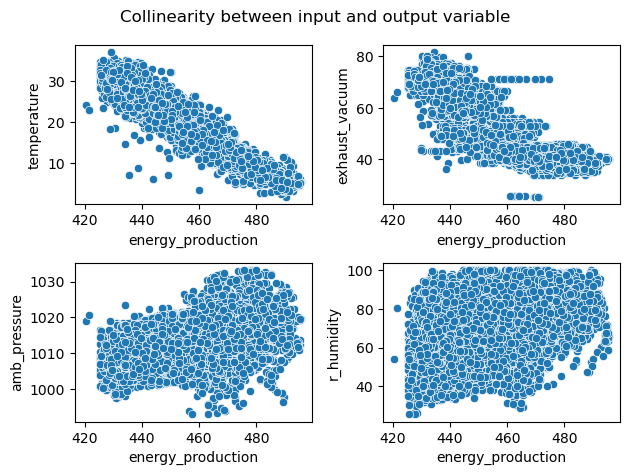

In [40]:
for i, j in enumerate(df.iloc[:, :-1].columns, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=df.iloc[:, -1], y=df[j])
    plt.suptitle('Collinearity between input and output variable')
plt.tight_layout()
plt.show()

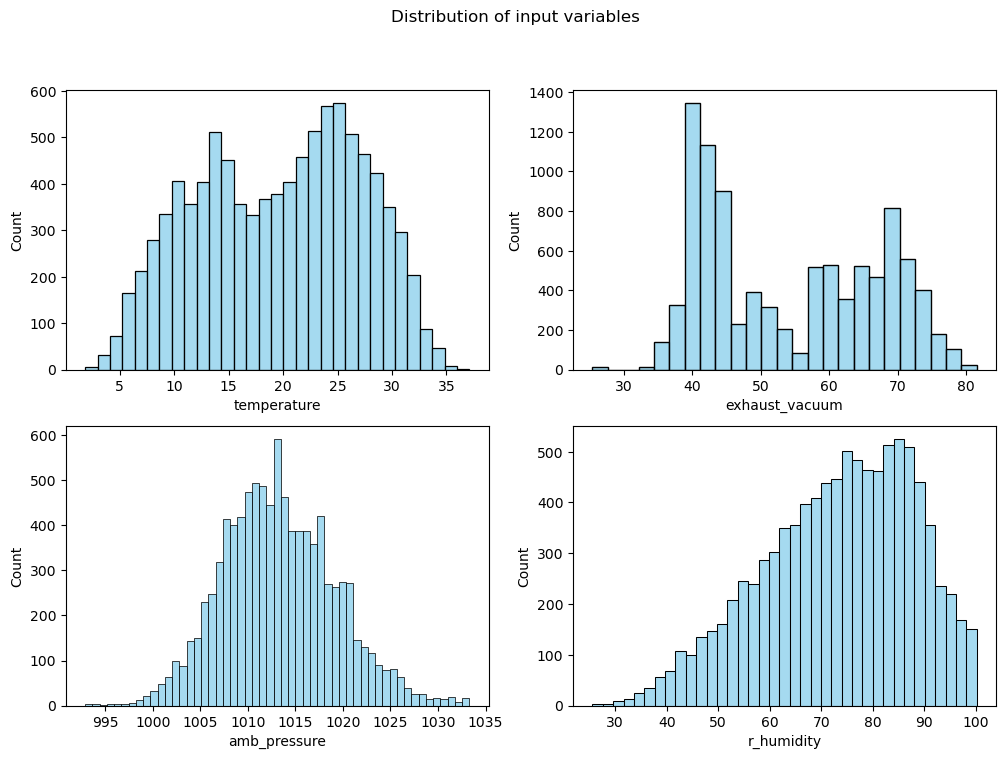

In [41]:
plt.figure(figsize=(12,8))
for i,j in enumerate(df.iloc[:,:-1].columns,1):
    plt.subplot(2,2,i)
    sns.histplot(df[j],color='skyblue')
    plt.suptitle('Distribution of input variables')
plt.show()

#### Temperature, ambient pressure, and relative humidity are approximately normally distributed, except for exhaust vacuum

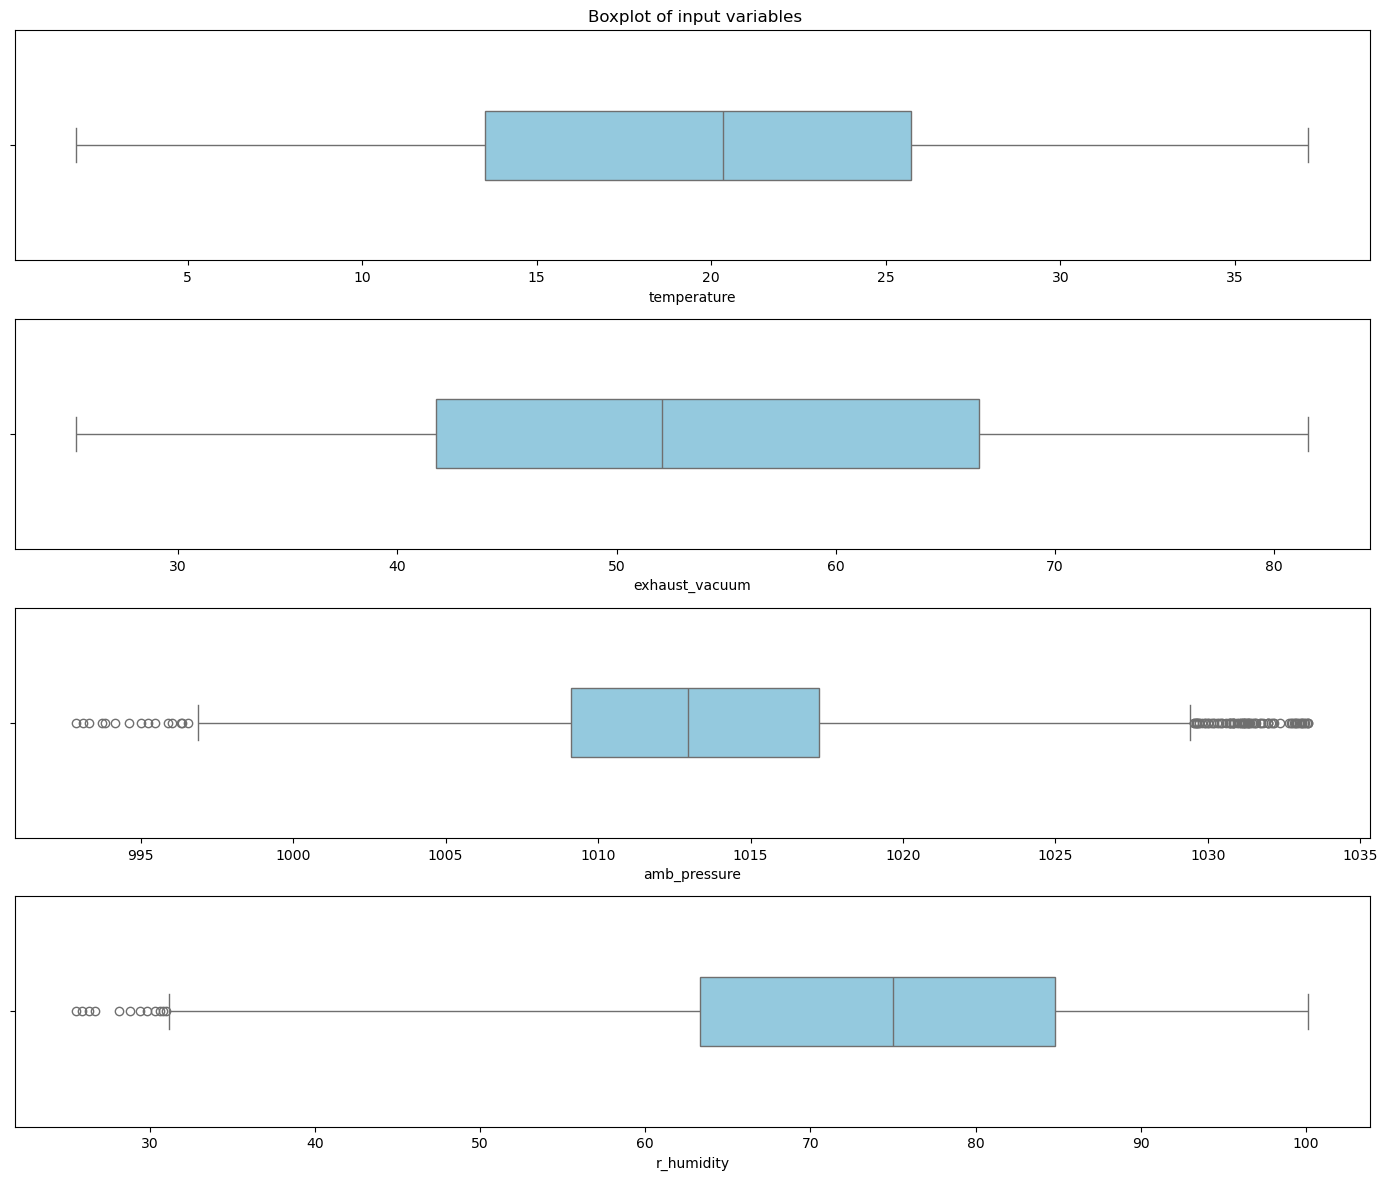

In [42]:
plt.figure(figsize=(14,12))
for i,j in enumerate(df.iloc[:,:-1].columns,1):
    plt.subplot(4,1,i)
    sns.boxplot(df[j],orient='h',color='skyblue',width=0.3)
    plt.suptitle('Boxplot of input variables')
plt.tight_layout()
plt.show()

#### Ambient pressure and relative humidity contain outliers that we will address.

# Data Preprocessing:

In [6]:
# Dropping duplicates
df_cleaned=df.drop_duplicates()
df_cleaned.reset_index(inplace=True)
df_cleaned=df_cleaned.drop('index',axis=1)

### Standardization

In [7]:
features = df_cleaned.drop(columns=['energy_production'])

# Fit the scaler only on features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Save the scaler for later use
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


# Saving the scaler for the model deployment excluding the output variable

In [8]:
df_transformed=df_cleaned.copy()
scaler=StandardScaler()
df_transformed=scaler.fit_transform(df_cleaned)

In [9]:
df_transformed=pd.DataFrame(df_transformed,columns=df_cleaned.columns)
df_transformed.head(3)

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
0,-1.352528,-1.240254,0.635148,-0.906085,1.582568
1,-1.023404,-0.942279,1.091361,1.460630,0.647023
2,-0.777569,-0.726287,1.882578,0.571999,0.654066


### Dropping Outliers:

In [10]:
df_transformed.shape

(9527, 5)

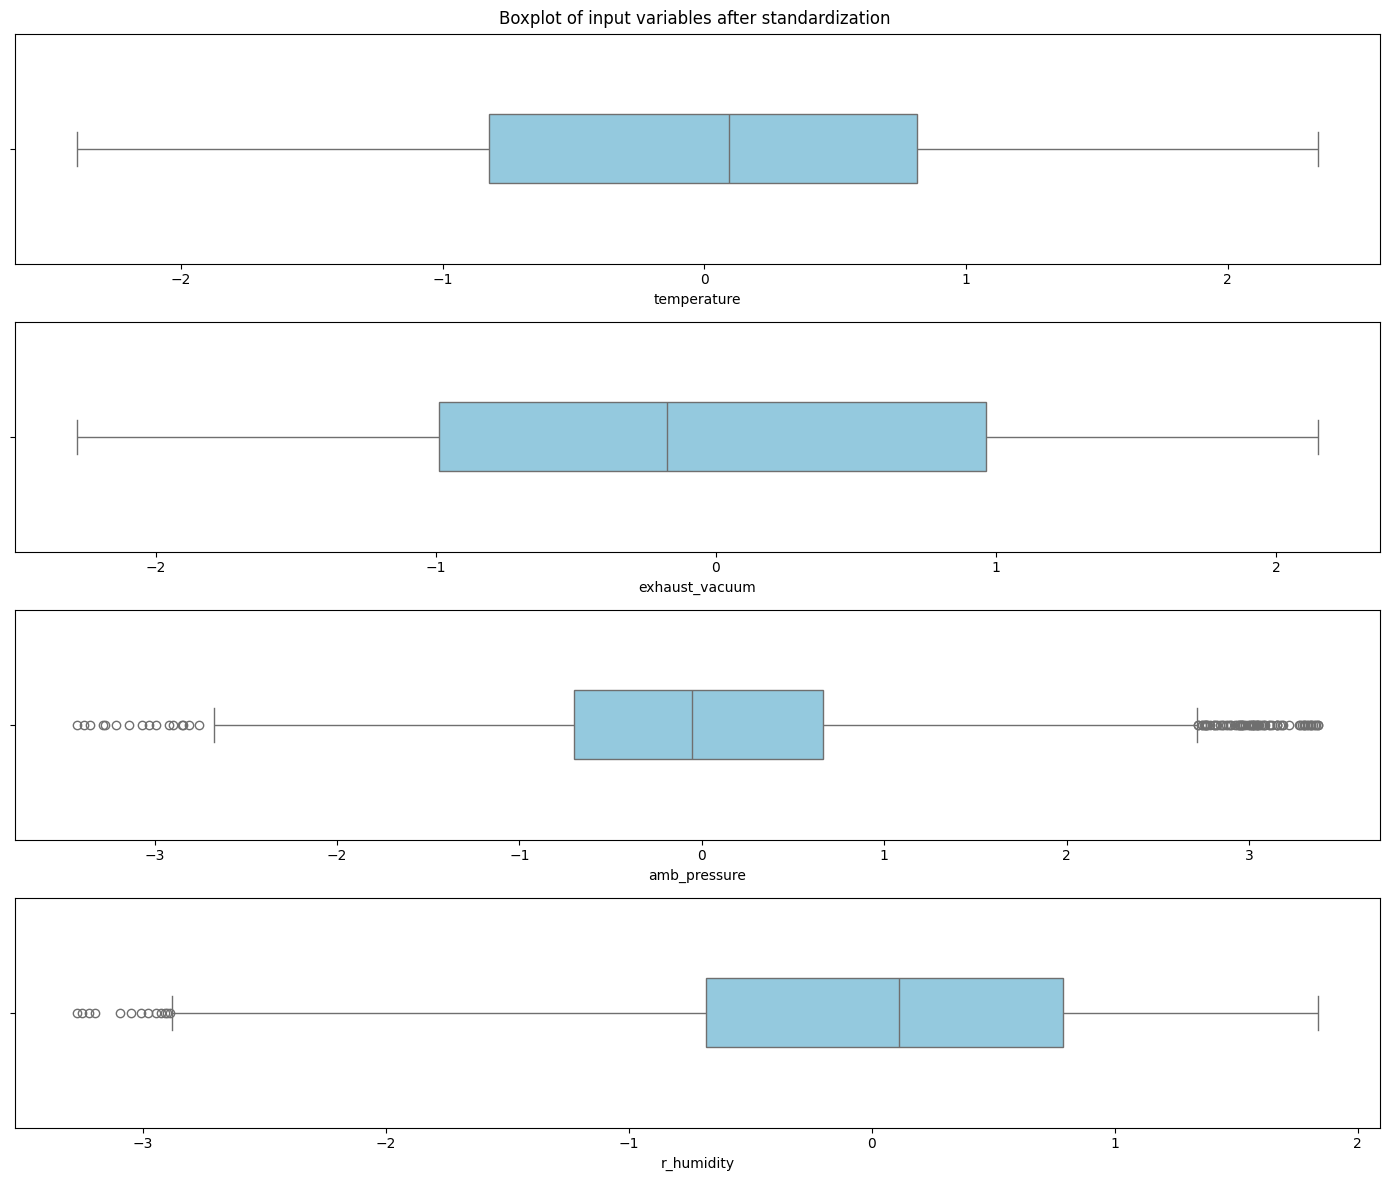

In [11]:
plt.figure(figsize=(14,12))
for i,j in enumerate(df_transformed.iloc[:,:-1].columns,1):
    plt.subplot(4,1,i)
    sns.boxplot(df_transformed[j],orient='h',color='skyblue',width=0.3)
    plt.suptitle('Boxplot of input variables after standardization')
plt.tight_layout()
plt.show()

In [12]:
outliers = (np.abs(df_transformed) >2.68)
outliers.sum()

temperature           0
exhaust_vacuum        0
amb_pressure         97
r_humidity           36
energy_production     0
dtype: int64

In [13]:
# Count outliers and calculate percentage
outlier_percentage = (outliers.sum().sum() / df_transformed.shape[0]) * 100
print(f"Count of outliers: {outliers.sum().sum()}")
print(f"Percentage of outliers: {outlier_percentage:.2f}%")

Count of outliers: 133
Percentage of outliers: 1.40%


In [14]:
# Dropping outliers
df_transformed2=df_transformed[np.abs(df_transformed)<2.686]
df_transformed2.dropna(inplace=True)
df_transformed2=df_transformed2.reset_index()
df_transformed2=df_transformed2.drop('index',axis=1)
df_transformed2.shape

(9397, 5)

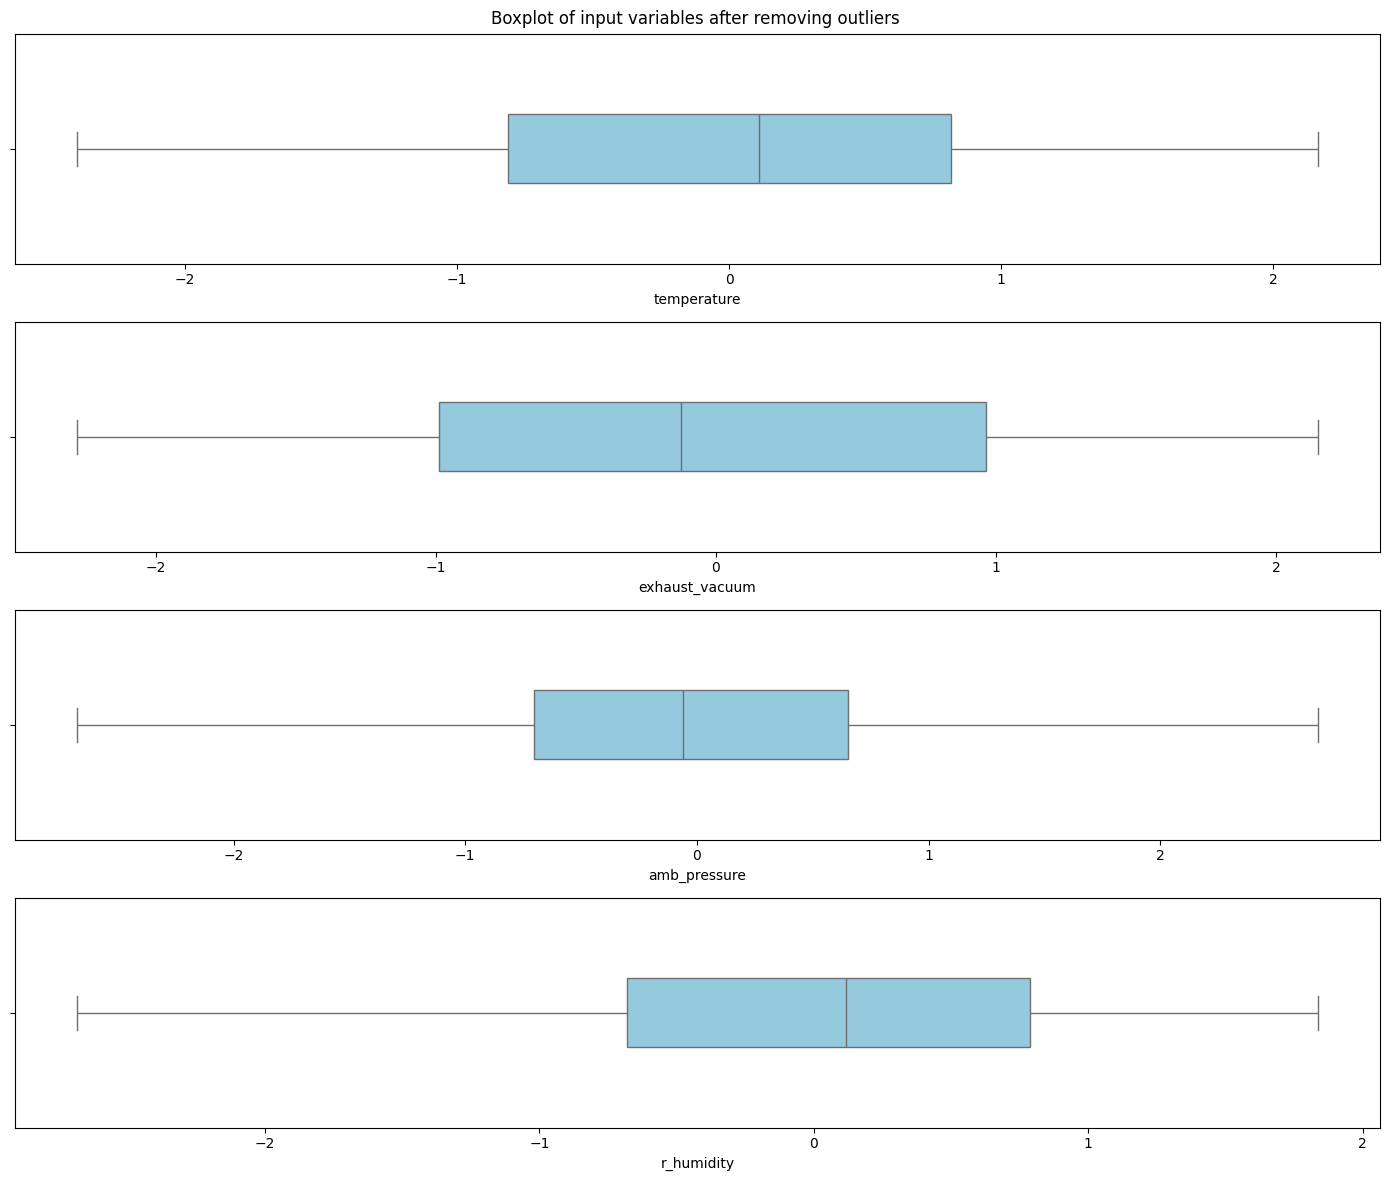

In [15]:
plt.figure(figsize=(14,12))
for i,j in enumerate(df_transformed2.iloc[:,:-1].columns,1):
    plt.subplot(4,1,i)
    sns.boxplot(df_transformed2[j],orient='h',color='skyblue',width=0.3)
    plt.suptitle('Boxplot of input variables after removing outliers')
plt.tight_layout()
plt.show()

## Addressing Multicollinearity Using Variance Inflation Factor (VIF)
- Multicollinearity occurs when independent variables in a regression model are highly correlated, making it difficult to assess the effect of each variable. Variance Inflation Factor (VIF) is a tool that helps detect multicollinearity by quantifying how much the variance of a regression coefficient is inflated due to collinearity among the predictors.

In [16]:
df_transformed2.columns

Index(['temperature', 'exhaust_vacuum', 'amb_pressure', 'r_humidity',
       'energy_production'],
      dtype='object')

In [17]:
vif_df=pd.DataFrame()
vif_df['Features']=df_transformed2.iloc[:,:-1].columns
vif_df['VIF']=[variance_inflation_factor(df_transformed2.iloc[:,:-1],i) for i in range(df_transformed2.iloc[:,:-1].shape[1])]
vif_df.sort_values(by='VIF')

,Features,VIF
2,amb_pressure,1.446245
3,r_humidity,1.691181
1,exhaust_vacuum,3.891306
0,temperature,5.870159


- VIF < 5: Generally considered low and indicates no significant multicollinearity.
- VIF between 5 and 10: Suggests moderate multicollinearity. This is a warning sign, but often not severe enough to require immediate action
- a score of 5.9 suggests that the variable is somewhat correlated with other predictors, it is not high enough to cause serious problems in most models.

In [18]:
vif_df=pd.DataFrame()
vif_df['Features']=df_transformed2.iloc[:,[1,2,3]].columns
vif_df['VIF']=[variance_inflation_factor(df_transformed2.iloc[:,[1,2,3]],i) for i in range(df_transformed2.iloc[:,[1,2,3]].shape[1])]
vif_df.sort_values(by='VIF')

,Features,VIF
2,r_humidity,1.105372
1,amb_pressure,1.212343
0,exhaust_vacuum,1.323727


## Split the data into train and test:

In [19]:
train,test=train_test_split(df_transformed2,test_size=0.3,random_state=0)
train=train.reset_index()
train=train.drop('index',axis=1)
train.shape,test.shape

((6577, 5), (2820, 5))

# Model building

## Linear Regression Model 1

In [30]:
model1=ols('energy_production ~ temperature + exhaust_vacuum + amb_pressure + r_humidity', data=train ).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      energy_production   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.112e+04
Date:                Sat, 28 Sep 2024   Prob (F-statistic):               0.00
Time:                        13:18:03   Log-Likelihood:                -664.43
No. Observations:                6577   AIC:                             1339.
Df Residuals:                    6572   BIC:                             1373.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0046      0.003      1.390      0.165      -0.002       0.011
temperature       -0.8583      0.008   -106.191      0.000      -0.874      -0.842
exhaust_vacuum    -0.1794      0.007    -27.319      0.000      -0.192      -0.166
amb_pressure       0.0255      0.004      6.169      0.000       0.017       0.034
r_humidity        -0.1377      0.004    -31.899      0.000      -0.146      -0.129
==============================================================================
Omnibus:                      775.764   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4157.353
Skew:                          -0.441   Prob(JB):                         0.00
Kurtosis:                       6.794   Cond. No.                         4.84
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### The AIC and BIC Values Are High, and the Data Exhibits Skewness and Kurtosis
Both the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) scores are elevated, indicating a potential issue with model fit. Additionally, the data shows signs of skewness and kurtosis, suggesting non-normality in the distribution of some features.

### Influencial observations

The goal is to assess the influence of each observation on the model’s overall predictions, parameters, or diagnostics. Some points may not be outliers but still have a disproportionate influence on the model.

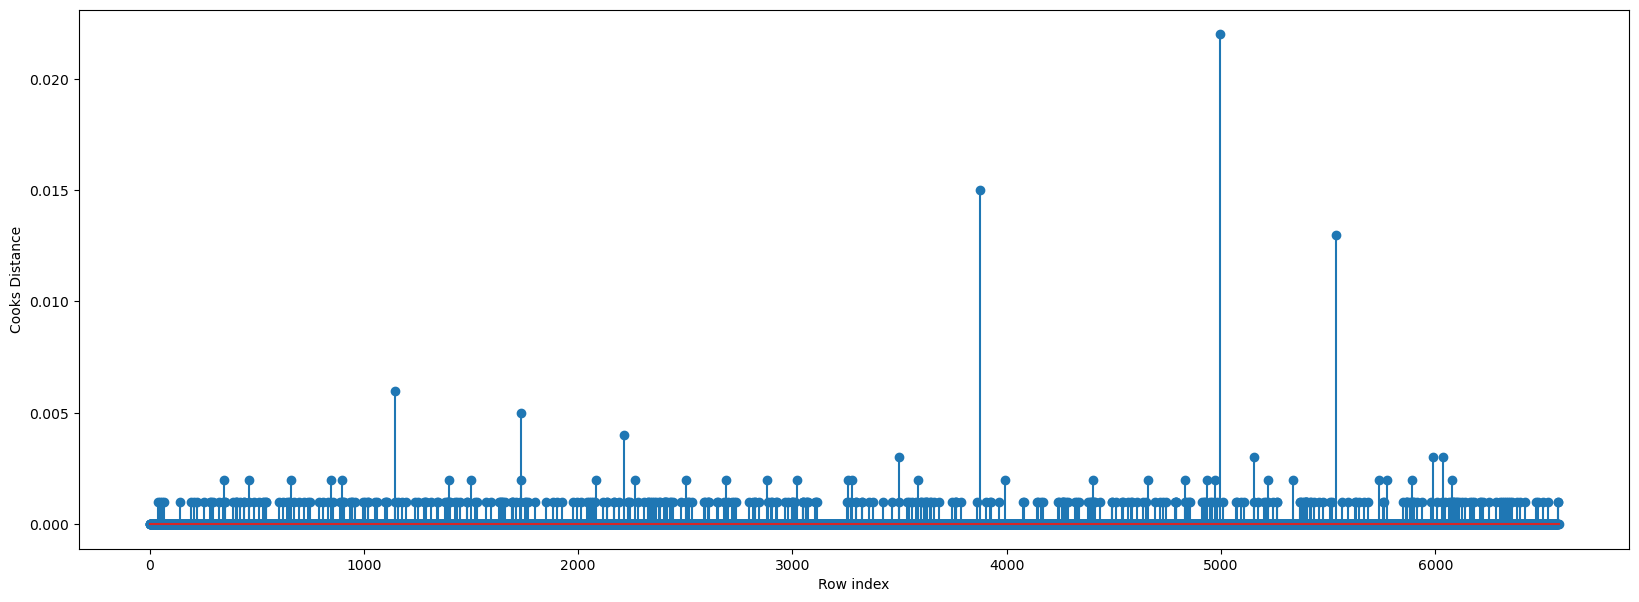

In [31]:
model_influence = model1.get_influence()
cooks=(c, _) = model_influence.cooks_distance   

#Plot the influencers values using stem plot
plt.figure(figsize=(20, 7))
plt.stem(np.arange(len(train)), np.round(c, 3))
plt.xlabel('Row index')
plt.ylabel('Cooks Distance')
plt.show()

In [32]:
threshold =0.001
indices= np.where(c>threshold)[0]
print(indices)
print(f"Count of imfluencial observations: {len(indices)}")

[ 297  343  349  350  404  440  465  466  527  534  541  602  660  833
  848  855  898  945 1003 1098 1143 1176 1342 1348 1390 1398 1404 1426
 1482 1502 1693 1710 1732 1735 1750 1766 1899 2014 2040 2079 2081 2136
 2168 2189 2213 2267 2325 2381 2415 2478 2504 2532 2585 2651 2688 2738
 2882 2967 3022 3103 3258 3271 3279 3295 3374 3495 3586 3602 3764 3873
 3994 4239 4261 4275 4381 4401 4403 4634 4661 4788 4833 4857 4926 4936
 4947 4974 4982 4994 5155 5219 5336 5399 5432 5507 5536 5626 5736 5775
 5890 5982 5988 6038 6077 6347 6571]
Count of imfluencial observations: 105


## Model 2 After Removing Influential Observations:

In [33]:
train2= train.drop(indices, axis=0)                     
train2=train2.reset_index()
train2=train2.drop('index',axis=1)
train2.shape

(6472, 5)

In [34]:
vif_df=pd.DataFrame()
vif_df['Features']=train2.iloc[:,:-1].columns
vif_df['VIF']=[variance_inflation_factor(train2.iloc[:,:-1],i) for i in range(train2.iloc[:,:-1].shape[1])]
vif_df.sort_values(by='VIF')

,Features,VIF
2,amb_pressure,1.462362
3,r_humidity,1.681219
1,exhaust_vacuum,3.962199
0,temperature,5.969307


### Still the same VIF score

In [35]:
# Not including exhaust vaccum as it had high VIF score
model2=ols('energy_production ~ temperature +exhaust_vacuum+ amb_pressure + r_humidity', data=train2 ).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      energy_production   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                 2.453e+04
Date:                Sat, 28 Sep 2024   Prob (F-statistic):               0.00
Time:                        13:18:41   Log-Likelihood:                -116.83
No. Observations:                6472   AIC:                             243.7
Df Residuals:                    6467   BIC:                             277.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0056      0.003      1.837      0.066      -0.000       0.012
temperature       -0.8663      0.008   -114.146      0.000      -0.881      -0.851
exhaust_vacuum    -0.1763      0.006    -28.804      0.000      -0.188      -0.164
amb_pressure       0.0262      0.004      6.784      0.000       0.019       0.034
r_humidity        -0.1353      0.004    -33.557      0.000      -0.143      -0.127
==============================================================================
Omnibus:                      119.005   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.946
Skew:                           0.058   Prob(JB):                     1.76e-15
Kurtosis:                       2.512   Cond. No.                         4.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### After removing influential observations, the AIC and BIC scores have decreased, indicating an improvement in model fit. Furthermore, both skewness and kurtosis have reduced, suggesting a more normalized data distribution. However, we identified that temperature exhibits multicollinearity with other variables. To address this, we will build model according to the Variance Inflation Factor (VIF) to assess and manage multicollinearity.

In [53]:
# split the data
train_x=train2.iloc[:,:-1]
test_x=test.iloc[:,:-1]
train_y=train2.iloc[:,-1]
test_y=test.iloc[:,-1]

## Exploring Models with Various Features Based on VIF Scores
We will analyze different models by selecting features according to their VIF scores, aiming to minimize multicollinearity and optimize model performance.

In [369]:
# dropping temprature
model3=ols('energy_production ~ exhaust_vacuum+ amb_pressure + r_humidity', data=train2 ).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      energy_production   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     9220.
Date:                Fri, 20 Sep 2024   Prob (F-statistic):               0.00
Time:                        15:47:15   Log-Likelihood:                -3695.1
No. Observations:                6467   AIC:                             7398.
Df Residuals:                    6463   BIC:                             7425.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0024      0.005     -0.453      0.650      -0.013       0.008
exhaust_vacuum    -0.7336      0.006   -118.588      0.000      -0.746      -0.721
amb_pressure       0.2130      0.006     34.631      0.000       0.201       0.225
r_humidity         0.1372      0.006     24.120      0.000       0.126       0.148
==============================================================================
Omnibus:                       92.653   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.620
Skew:                           0.280   Prob(JB):                     6.34e-22
Kurtosis:                       3.218   Cond. No.                         1.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Removing the temperature variable leads to a substantial increase in both the AIC and BIC scores, suggesting that the model is no longer a good fit for the data.

In [378]:
# dropping exhaust vacuum
model4=ols('energy_production ~ temperature + amb_pressure + r_humidity', data=train2 ).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      energy_production   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 2.840e+04
Date:                Fri, 20 Sep 2024   Prob (F-statistic):               0.00
Time:                        15:52:01   Log-Likelihood:                -499.88
No. Observations:                6467   AIC:                             1008.
Df Residuals:                    6463   BIC:                             1035.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0069      0.003      2.127      0.033       0.001       0.013
temperature     -1.0373      0.005   -220.627      0.000      -1.047      -1.028
amb_pressure     0.0164      0.004      3.998      0.000       0.008       0.024
r_humidity      -0.1731      0.004    -42.861      0.000      -0.181      -0.165
==============================================================================
Omnibus:                       89.015   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.331
Skew:                           0.063   Prob(JB):                     9.66e-13
Kurtosis:                       2.565   Cond. No.                         2.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [380]:
model5=ols('energy_production ~ temperature+  r_humidity', data=train2 ).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      energy_production   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 4.249e+04
Date:                Fri, 20 Sep 2024   Prob (F-statistic):               0.00
Time:                        15:52:13   Log-Likelihood:                -507.86
No. Observations:                6467   AIC:                             1022.
Df Residuals:                    6464   BIC:                             1042.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0069      0.003      2.121      0.034       0.001       0.013
temperature    -1.0476      0.004   -266.035      0.000      -1.055      -1.040
r_humidity     -0.1769      0.004    -44.994      0.000      -0.185      -0.169
==============================================================================
Omnibus:                       77.192   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.346
Skew:                           0.057   Prob(JB):                     1.93e-11
Kurtosis:                       2.587   Cond. No.                         1.84
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [382]:
model6=ols('energy_production ~ temperature +  amb_pressure',data=train2 ).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      energy_production   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                 3.246e+04
Date:                Fri, 20 Sep 2024   Prob (F-statistic):               0.00
Time:                        15:52:25   Log-Likelihood:                -1308.8
No. Observations:                6467   AIC:                             2624.
Df Residuals:                    6464   BIC:                             2644.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0044      0.004      1.187      0.235      -0.003       0.012
temperature     -0.9222      0.004   -210.902      0.000      -0.931      -0.914
amb_pressure     0.0574      0.005     12.729      0.000       0.049       0.066
==============================================================================
Omnibus:                       56.721   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.575
Skew:                           0.049   Prob(JB):                     4.20e-09
Kurtosis:                       2.635   Cond. No.                         1.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Despite using the Variance Inflation Factor (VIF) to assess multicollinearity, the scores were inconclusive and did not clearly indicate which features should be removed or adjusted for better model performance.

# Lasso Regression:

In [55]:
train_x=train.iloc[:,:-1]
test_x=test.iloc[:,:-1]
train_y=train.iloc[:,-1]
test_y=test.iloc[:,-1]

In [192]:
alphas = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Use GridSearchCV to find the best alpha value
lasso_cv = GridSearchCV(Lasso(), alphas, cv=5)
lasso_cv.fit(train_x,train_y)

# View the best alpha value
print(f"Best alpha value: {lasso_cv.best_params_}")

Best alpha value: {'alpha': 0.01}


In [56]:
lasso_model=Lasso(alpha=0.01)
lasso_model.fit(train_x,train_y)

Lasso(alpha=0.01)

In [57]:
train_pred=lasso_model.predict(train_x)
y_pred = lasso_model.predict(test_x)

print("Test MSE:", mean_squared_error(test_y, y_pred))
print("Train MSE:",mean_squared_error(train_y, train_pred))
print("Test R-squared (R2):", r2_score(test_y, y_pred))
print("Train R-squared:",r2_score(train_y,train_pred))

Test MSE: 0.0728464960352042
Train MSE: 0.07211039898623765
Test R-squared (R2): 0.9268391317424535
Train R-squared: 0.927377877585516


# Ridge Regression

In [195]:
alphas = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Use GridSearchCV to find the best alpha value
ridge_cv = GridSearchCV(Ridge(), alphas, cv=5)
ridge_cv.fit(train_x,train_y)

# View the best alpha value
print(f"Best alpha value: {ridge_cv.best_params_}")

Best alpha value: {'alpha': 0.1}


In [196]:
ridge_model=Ridge(alpha=0.01)
ridge_model.fit(train_x,train_y)

Ridge(alpha=0.01)

In [197]:
train_pred=ridge_model.predict(train_x)
y_pred = ridge_model.predict(test_x)

print("Test MSE:", mean_squared_error(test_y, y_pred))
print("Train MSE:",mean_squared_error(train_y, train_pred))
print("Test R-squared (R2):", r2_score(test_y, y_pred))
print("Train R-squared:",r2_score(train_y,train_pred))

Test MSE: 0.07239818018802757
Train MSE: 0.060693756409285676
Test R-squared (R2): 0.9271877124674374
Train R-squared: 0.9383345344066318


# Elastic net
- Elastic Net combines the penalties of both Lasso Regression (L1) and Ridge Regression (L2). This allows it to effectively handle multicollinearity by stabilizing coefficient estimates while also promoting sparsity in the model.

In [198]:
# Define a range of alpha values to test
alphas = {'alpha': [0.01, 0.1, 1, 10, 100],'l1_ratio':[0.1,0.2,0.3,0.5]}

# Use GridSearchCV to find the best alpha value
ridge_cv = GridSearchCV(ElasticNet(), alphas, cv=5)
ridge_cv.fit(train_x,train_y)

# View the best alpha value
print(f"Best alpha value: {ridge_cv.best_params_}")


Best alpha value: {'alpha': 0.01, 'l1_ratio': 0.3}


In [199]:
elastic_model=ElasticNet(alpha = 0.01,l1_ratio=0.3)
elastic_model.fit(train_x,train_y)

ElasticNet(alpha=0.01, l1_ratio=0.3)

In [200]:
train_pred=elastic_model.predict(train_x)
y_pred = elastic_model.predict(test_x)
print("Model Coefficients:", elastic_model.coef_)
print("Intercept:", elastic_model.intercept_)
print("Test MSE:", mean_squared_error(test_y, y_pred))
print("Train MSE:",mean_squared_error(train_y, train_pred))
print("Test R-squared (R2):", r2_score(test_y, y_pred))
print("Train R-squared:",r2_score(train_y,train_pred))

Model Coefficients: [-0.82973171 -0.19262276  0.03261777 -0.11652721]
Intercept: 0.004694494654815673
Test MSE: 0.07271053322353609
Train MSE: 0.060999087717304716
Test R-squared (R2): 0.9268735728167714
Train R-squared: 0.9380243147335857


# PCA & Linear regression

- PCA is a powerful technique for addressing multicollinearity by transforming correlated features into a set of uncorrelated principal components, thus improving model performance and stability.

In [21]:
pca = PCA()  
pca.fit(train_x)
pca.explained_variance_ratio_*100

array([61.69791992, 22.06668437, 13.56196179,  2.67343392])

In [24]:
pd.DataFrame(np.cumsum(pca.explained_variance_ratio_*100))

,0
0,61.697920
1,83.764604
2,97.326566
3,100.000000


In [106]:
pca = PCA(n_components=3)  
X_train_pca = pca.fit_transform(train_x)
X_test_pca = pca.transform(test_x)

test_pca_df = pd.DataFrame(data=X_test_pca, columns=['PC1', 'PC2', 'PC3'])
test_pca_df['energy_production'] = test_y.values


# DataFrame for the principal components
train_pca_df = pd.DataFrame(data=X_train_pca, columns=['PC1', 'PC2','PC3'])
train_pca_df['energy_production'] = train_y.values


pca_train_x=train_pca_df.iloc[:,:-1]
pca_test_x=test_pca_df.iloc[:,:-1]
pca_train_y=train_pca_df['energy_production']
pca_test_y=test_pca_df['energy_production']

train_pca_df.head(3)

,PC1,PC2,PC3,energy_production
0,2.010599,0.597160,0.215540,-1.285695
1,1.489223,-0.226107,-1.240125,-0.901851
2,1.450068,0.242897,-0.020892,-0.993997


In [26]:
vif_df=pd.DataFrame()
vif_df['Features']=pca_train_x.columns
vif_df['VIF']=[variance_inflation_factor(pca_train_x,i) for i in range(pca_train_x.shape[1])]
vif_df.sort_values(by='VIF')

,Features,VIF
2,PC3,1.0
1,PC2,1.0
0,PC1,1.0


In [41]:
# Fit OLS using the principal components
model_pca = ols('energy_production ~ PC1 + PC2 + PC3 ', data=train_pca_df).fit()

# model summary
model_pca.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      energy_production   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                 1.974e+04
Date:                Sat, 28 Sep 2024   Prob (F-statistic):               0.00
Time:                        13:20:16   Log-Likelihood:                -1622.4
No. Observations:                6472   AIC:                             3253.
Df Residuals:                    6468   BIC:                             3280.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0081      0.004     -2.092      0.036      -0.016      -0.001
PC1           -0.5924      0.003   -235.989      0.000      -0.597      -0.587
PC2           -0.1198      0.004    -28.734      0.000      -0.128      -0.112
PC3           -0.2780      0.005    -52.047      0.000      -0.289      -0.268
==============================================================================
Omnibus:                       18.861   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.522
Skew:                           0.044   Prob(JB):                     0.000426
Kurtosis:                       2.777   Cond. No.                         2.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
y_pred = model_pca.predict(pca_test_x)
test_mse = mean_squared_error(pca_test_y, y_pred)
rsquared=model_pca.rsquared
train_mse=model_pca.mse_resid
test_rsquared=r2_score(pca_test_y, y_pred)
print("Train MSE:",train_mse)
print("Test MSE:", test_mse)
print("Test rsquared:",np.round(test_rsquared,3))
print("Train Rsquared:",np.round(rsquared,3))

Train MSE: 0.09672450714896598
Test MSE: 0.11115026886879673
Test rsquared: 0.888
Train Rsquared: 0.902


# PCA & Support Vector Regression:

## Hyperparameter Tuning

In [35]:
params = {'kernel': ['linear','rbf','poly']}

svr_cv = GridSearchCV(SVR(), params, cv=5)
svr_cv.fit(pca_train_x,pca_train_y)

print(f"Best params: {svr_cv.best_params_}")

Best params: {'kernel': 'rbf'}


In [205]:
svr = SVR(kernel='rbf')
svr.fit(pca_train_x,pca_train_y)

SVR()

In [206]:
ypred = svr.predict(pca_test_x)
train_pred=svr.predict(pca_train_x)
train_rsq=svr.score(pca_train_x,pca_train_y)
test_rsq=svr.score(pca_test_x,pca_test_y)
print("Train MSE:",mean_squared_error(pca_train_y,train_pred))
print("Test MSE:", mean_squared_error(pca_test_y,ypred))
print("Test rsquared:",np.round(test_rsq,3))
print("Train Rsquared:",np.round(train_rsq,3))

Train MSE: 0.0453223360098647
Test MSE: 0.05579529040541163
Test rsquared: 0.944
Train Rsquared: 0.954


# Ensemble TEchniques

In [82]:
train_x=train.iloc[:,:-1]
test_x=test.iloc[:,:-1]
train_y=train.iloc[:,-1]
test_y=test.iloc[:,-1]

## Bagging:

In [208]:

kfold = KFold(n_splits=10, random_state=seed,shuffle=True)
cart = SVR()
num_trees = 100
model = BaggingRegressor(estimator=cart, n_estimators=num_trees, random_state=seed)
results = cross_val_score(model, train_x, train_y, cv=kfold)
print(results.mean())

0.9521700937894446


## AdaBoost:

In [51]:
num_trees = 10

kfold = KFold(n_splits=10, random_state=seed,shuffle=True)
model = AdaBoostRegressor(n_estimators=num_trees, random_state=seed)
results = cross_val_score(model,train_x, train_y , cv=kfold)
print(results.mean())

0.9048070753815504


## RandomForest

In [45]:
num_trees = 300
max_features = 3
kfold = KFold(n_splits=10, random_state=7,shuffle=True)
model = RandomForestRegressor(n_estimators=num_trees, max_features=max_features,n_jobs=4)
results = cross_val_score(model, train_x, train_y, cv=kfold)
print(results.mean())

0.9670372417728144


## XGBoost

In [46]:
num_trees = 100

kfold = KFold(n_splits=10, random_state=seed,shuffle=True)
model = XGBRegressor( random_state=seed,n_estimators=300,learning_rate=0.2,reg_lambda=0.8,n_jobs=9)
results = cross_val_score(model,train_x, train_y , cv=kfold)
print(results.mean())

0.9724500003213186


## LGBMBoost

In [191]:
params={'learning_rate':[0.1,0.01,0.2,0.3],
        'n_estimators':[100,200,300,500],
        'max_depth':[3,5,7],
        'num_leaves':[30,20,40],
        'min_data_in_leaf':[50,30,20,25],
       'min_child_samples':[10,20,30,40],
       'reg_lambda':[0.2,0.5,0.7]}
rs_cv = RandomizedSearchCV(estimator=LGBMRegressor(), param_distributions=params, cv=5, n_iter=10, random_state=7,n_jobs=6)

rs_cv.fit(train_x,train_y)
print(f"Best params: {rs_cv.best_params_}")

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 6472, number of used features: 4
[LightGBM] [Info] Start training from score -0.001404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [103]:
from sklearn.model_selection import KFold, cross_val_score
from lightgbm import LGBMRegressor

# Define seed and KFold with shuffling enabled
seed = 7
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Define the model
model = LGBMRegressor(random_state=seed, n_estimators=300,reg_lambda=0.5, learning_rate=0.1, max_depth=5, force_col_wise=True, 
                      num_leaves=30,min_child_samples=30,min_data_in_leaf=30)

results = cross_val_score(model, train_x, train_y, cv=kfold)
print(results.mean())


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Total Bins 1019
[LightGBM] [Info] Number of data points in the train set: 5260, number of used features: 4
[LightGBM] [Info] Start training from score -0.023488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

# Stacking 

In [240]:
from sklearn.ensemble import VotingRegressor

estimator=[]
model1=DecisionTreeRegressor(max_depth=3, min_samples_split=2)
estimator.append(('tree',model1))
model2=RandomForestRegressor()
estimator.append(('rf',model2))
model3=SVR(kernel='rbf')
estimator.append(('svm',model3))

kfold = KFold(n_splits=10, random_state=seed,shuffle=True)

stack_model=VotingRegressor(estimator)
stack_model.fit(train_x,train_y)
result=cross_val_score(stack_model,train_x,train_y,cv=kfold)
result.mean()

0.9557383327057842

# Choosing the best Model

In [86]:


def find_best_model_using_randomsearchcv(x, y,test_x,test_y):
    # Define algorithms and their hyperparameters
    algos = {
        'linear_regression': {'model': LinearRegression(), 'params': {}},
        'ridge': {'model': Ridge(random_state=10), 'params': {'alpha': [0.1, 0.5, 1]}},
        'lasso': {'model': Lasso(random_state=10), 'params': {'alpha': [0.1, 0.5, 1], 'selection': ['random', 'cyclic']}},
        'elastic_net': {'model': ElasticNet(random_state=10), 'params': {'alpha': [0.1, 0.5, 1], 'l1_ratio': [0.3, 0.5]}},
        'decision_tree': {'model': DecisionTreeRegressor(random_state=10), 'params': {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10]}},
        'Bagging':{'model':BaggingRegressor(random_state=10),'params':{'n_estimators':[100, 150, 200, 300]}},
        'AdaBoost':{'model':AdaBoostRegressor(random_state=10),'params':{'n_estimators':[100, 150, 200, 300]}},
        'random_forest': {'model': RandomForestRegressor(random_state=10), 'params': {'n_estimators': [100, 150, 200, 300], 'max_features': [3, 4]}},
        'xgboost': {'model': XGBRegressor(random_state=10), 'params': {'n_estimators': [100, 150, 200, 250], 'max_depth': [3, 4, 5], 'learning_rate': [0.1, 0.2], 'reg_lambda': [0.8, 0.5, 0.3]}},
        'svm': {'model': SVR(), 'params': {'kernel': ['rbf']}},
    }

    # List to store the best model scores
    scores = []

    # Cross-validation setup
    kfold = KFold(n_splits=10, random_state=seed,shuffle=True)

    # Iterate over each algorithm and perform RandomizedSearchCV
    for algo_name, config in algos.items():
        rs = RandomizedSearchCV(config['model'], config['params'], cv=kfold, n_iter=4, random_state=10)
        rs.fit(x, y)

        # Predict the target values using the best estimator
        y_pred = rs.best_estimator_.predict(x)
        test_pred=rs.best_estimator_.predict(test_x)
        
        test_score=r2_score(test_y, test_pred)
        train_mse = mean_squared_error(y, y_pred)
        test_mse = mean_squared_error(test_y, test_pred)

        scores.append({
            'model': algo_name,
            'best_params': rs.best_params_,
            'best_score': rs.best_score_*100,
            'Train MSE': train_mse,  
            'Test MSE': test_mse,
            'Test Score':test_score*100
        })

        # Print MSE for each model
        #print(f"{algo_name} - MSE: {mse:.4f}")

    # Return the results as a DataFrame
    return pd.DataFrame(scores, columns=['model', 'best_params','best_score', 'Train MSE','Test MSE','Test Score'])


In [87]:
# Passing the PCA data
find_best_model_using_randomsearchcv(pca_train_x,pca_train_y,pca_test_x,pca_test_y)

,model,best_params,best_score,Train MSE,Test MSE,Test Score
0,linear_regression,{},92.756521,0.071660,0.072549,92.713818
1,ridge,{'alpha': 0.5},92.756524,0.071660,0.072550,92.713713
2,lasso,"{'selection': 'random', 'alpha': 0.1}",85.682619,0.141844,0.141259,85.813122
3,elastic_net,"{'l1_ratio': 0.3, 'alpha': 0.1}",90.277486,0.096269,0.097597,90.198228
4,decision_tree,"{'min_samples_split': 2, 'max_depth': 7}",92.178233,0.060264,0.078474,92.118698
5,Bagging,{'n_estimators': 300},94.863259,0.006875,0.047705,95.208934
6,AdaBoost,{'n_estimators': 150},87.541496,0.120843,0.122338,87.713450
7,random_forest,"{'n_estimators': 300, 'max_features': 3}",94.932827,0.006775,0.047464,95.233119
8,xgboost,"{'reg_lambda': 0.3, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}",94.362940,0.038880,0.055051,94.471095
9,svm,{'kernel': 'rbf'},94.287255,0.054627,0.056056,94.370249


In [47]:
# Set display options to ensure the full content is displayed
pd.set_option('display.max_colwidth', None)       
pd.set_option('display.max_columns', None)

In [58]:
# Passing the data
find_best_model_using_randomsearchcv(train_x,train_y,test_x,test_y)

,model,best_params,best_score,Train MSE,Test MSE,Test Score
0,linear_regression,{},92.756521,0.071660,0.072549,92.713818
1,ridge,{'alpha': 0.5},92.756524,0.071660,0.072550,92.713713
2,lasso,"{'selection': 'random', 'alpha': 0.1}",90.299383,0.096042,0.095735,90.385228
3,elastic_net,"{'l1_ratio': 0.3, 'alpha': 0.1}",91.182323,0.087297,0.088147,91.147298
4,decision_tree,"{'min_samples_split': 10, 'max_depth': 7}",93.844897,0.046832,0.060252,93.948768
5,Bagging,{'n_estimators': 300},95.813168,0.005547,0.040118,95.970869
6,AdaBoost,{'n_estimators': 100},89.628537,0.099576,0.104346,89.520348
7,random_forest,"{'n_estimators': 300, 'max_features': 3}",95.930105,0.005437,0.038930,96.090238
8,xgboost,"{'reg_lambda': 0.8, 'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.2}",96.337093,0.011641,0.034557,96.529340
9,svm,{'kernel': 'rbf'},94.287261,0.054630,0.056064,94.369389


### Based on the data, it is clear that models without PCA are performing significantly better. Here's a breakdown of the key insights:

- Linear Regression, Ridge, and Lasso models show similar performance, with Ridge and Linear Regression yielding identical results (Test Score: 0.927188). However, the Lasso model underperforms slightly compared to these two, with a lower test score of 0.903522.

- Elastic Net strikes a balance between Ridge and Lasso, providing slightly better results than Lasso (Test Score: 0.910632) but still not on par with Ridge or Linear Regression.

- Decision Tree performs better, with a test score of 0.942274, showing improvement over the linear models.

- Bagging and Random Forest emerge as strong contenders. The Random Forest model, with n_estimators: 300 and max_features: 3, has the second-best performance overall (Test Score: 0.961611). Bagging also delivers a high test score of 0.960770, which is quite close to Random Forest.

- XGBoost delivers the best results among all models, with the highest test score of 0.965424 and low test MSE of 0.034379. This makes it the top-performing model in this comparison.

- SVM with RBF kernel shows solid performance as well, with a test score of 0.943886, but does not outperform tree-based ensemble models like Random Forest or XGBoost.

### Conclusion:
- In summary, the Random Forest and XGBoost models outperform others, demonstrating high consistency across both train and test datasets. These models also exhibit robust results without overfitting, as indicated by their similar train and test scores.

# Chosen best model- XGBOOST

In [83]:

kfold = KFold(n_splits=10, random_state=seed,shuffle=True)

final_model=XGBRegressor(n_estimators=250,reg_lambda=0.8,max_depth=5,learning_rate=0.2,random_state=seed)
final_model.fit(train_x, train_y)
results = cross_val_score(final_model, train_x, train_y, cv=kfold)

train_pred=final_model.predict(train_x)
y_pred = final_model.predict(test_x)

print("Test MSE:", mean_squared_error(test_y, y_pred))
print("Train MSE:",mean_squared_error(train_y, train_pred))
print("Test R-squared (R2):", r2_score(test_y, y_pred))
print("Train R-squared:",results.mean())

Test MSE: 0.0345574682627305
Train MSE: 0.01164100227107246
Test R-squared (R2): 0.9652933974797888
Train R-squared: 0.9633709289745152


In [84]:
with open('Regression_model','wb') as file:
    pickle.dump(final_model,file)